In [1]:
# Import necessary modules

import os
import sys
import numpy as np
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt

import torch.nn.functional as F


In [2]:
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'
import os
import torch

from pytorch3d.transforms.so3 import (
    so3_exp_map,
    so3_relative_angle,
    so3_log_map,
)


In [3]:
# Input Convex Neural Network

class ICNN(nn.Module):
    def __init__(self, layer_sizes, activation=F.relu_):
        super().__init__()
        
        self.W = nn.ParameterList([nn.Parameter(torch.Tensor(l, layer_sizes[0]**2)) 
                                   for l in layer_sizes[1:]])
        self.U = nn.ParameterList([nn.Parameter(torch.Tensor(layer_sizes[i+1], layer_sizes[i]))
                                   for i in range(1,len(layer_sizes)-1)])
        self.bias = nn.ParameterList([nn.Parameter(torch.Tensor(l)) for l in layer_sizes[1:]])
        self.act = activation
        self.reset_parameters()
        

    def reset_parameters(self):
        # copying from PyTorch Linear
        for W in self.W:
            nn.init.kaiming_uniform_(W, a=5**0.5)
        for U in self.U:
            nn.init.kaiming_uniform_(U, a=5**0.5)
        for i,b in enumerate(self.bias):
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W[i])
            bound = 1 / (fan_in**0.5)
            nn.init.uniform_(b, -bound, bound)
        
#         for p in model.parameters():
#             p.data.fill_(0)

    def forward(self, x):
        # Reshape the 3x3 matrix x into a vector to obtain the trace tr[Wx]+b
        xr = torch.reshape(x,(-1,))
        z = F.linear(xr, self.W[0], self.bias[0])
        z = self.act(z)

        for W,b,U in zip(self.W[1:-1], self.bias[1:-1], self.U[:-1]):
            z = F.linear(xr, W, b) + F.linear(z, F.softplus(U)) / U.shape[0]
            z = self.act(z)

        return F.linear(xr, self.W[-1], self.bias[-1]) + F.linear(z, F.softplus(self.U[-1])) / self.U[-1].shape[0]
    
class ICNN2(nn.Module):
    def __init__(self, layer_sizes, activation=F.relu_):
        super().__init__()
        
        self.W = nn.ParameterList([nn.Parameter(torch.Tensor(l, layer_sizes[0]**2)) 
                                   for l in layer_sizes[1:]])
        self.U = nn.ParameterList([nn.Parameter(torch.Tensor(layer_sizes[i+1], layer_sizes[i]))
                                   for i in range(1,len(layer_sizes)-1)])
        self.bias = nn.ParameterList([nn.Parameter(torch.Tensor(l)) for l in layer_sizes[1:]])
        self.act = activation
        self.reset_parameters()
        

    def reset_parameters(self):
        # copying from PyTorch Linear
        for W in self.W:
            nn.init.kaiming_uniform_(W, a=5**0.5)
        for U in self.U:
            nn.init.kaiming_uniform_(U, a=5**0.5)
        for i,b in enumerate(self.bias):
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W[i])
            bound = 1 / (fan_in**0.5)
            nn.init.uniform_(b, -bound, bound)
        
#         for p in model.parameters():
#             p.data.fill_(0)

    def forward(self, x):
        # Reshape the 3x3 matrix x into a vector to obtain the trace tr[Wx]+b
        xr = torch.reshape(0.5*(x+x.permute(1,0)),(-1,))
        z = F.linear(xr, self.W[0], self.bias[0])
        z = self.act(z)

        for W,b,U in zip(self.W[1:-1], self.bias[1:-1], self.U[:-1]):
            z = F.linear(xr, W, b) + F.linear(z, F.softplus(U)) / U.shape[0]
            z = self.act(z)

        return F.linear(xr, self.W[-1], self.bias[-1]) + F.linear(z, F.softplus(self.U[-1])) / self.U[-1].shape[0]


# Rectified Huber unit - modified ReLU to make it smooth    
class ReHU(nn.Module):
    """ Rectified Huber unit"""
    def __init__(self, d):
        super().__init__()
        self.a = 1/d
        self.b = -d/2

    def forward(self, x):
        return torch.max(torch.clamp(torch.sign(x)*self.a/2*x**2,min=0,max=-self.b),x+self.b)

# Adding a quadratic term to make it PSD    
class MakePSD(nn.Module):
    def __init__(self, f, n, eps=0.01, d=1.0, w1 = 1.0, w2 = 1.0):
        super().__init__()
        self.f = f
        self.zero = nn.Parameter(f(torch.eye(3, dtype = torch.float32)), requires_grad=False)
        self.eps = eps
        self.d = d
        self.rehu = ReHU(self.d)
        self.w1 = w1
        self.w2 = w2

    def forward(self, x):
        smoothed_output = self.rehu(self.f(x) - self.zero)
        quadratic_under = self.eps*torch.trace(torch.eye(3, dtype = torch.float32)-x) #self.eps*(x**2).sum(1,keepdim=True)
        
        '''
        w1 and w2 are weights on the output and the quadratic term.
        w1 = 0 makes the output the Frobenius norm eps*tr[I - Rd'*R]
        '''
    
        return self.w1*smoothed_output + self.w2*quadratic_under
    
class MakePSD2(nn.Module):
    def __init__(self, f, n, eps=0.01, d=1.0, w1 = 1.0, w2 = 1.0):
        super().__init__()
        self.f = f
        self.zero = nn.Parameter(f(torch.eye(3, dtype = torch.float32)), requires_grad=False)
        self.eps = eps
        self.d = d
        self.rehu = ReHU(self.d)
        self.w1 = w1
        self.w2 = w2

    def forward(self, x):
        smoothed_output = self.rehu(self.f(x) - self.zero)
        quadratic_under = torch.norm(self.eps*so3_log_map(x.unsqueeze(0))[0])**2 #self.eps*(x**2).sum(1,keepdim=True)
        
        '''
        w1 and w2 are weights on the output and the quadratic term.
        w1 = 0 makes the output the Frobenius norm eps*||log[Rd'*R]||_F^2
        '''
    
        return self.w1*smoothed_output + self.w2*quadratic_under



def configure():

    lsd = 3
    ph_dim = 14 #16 
    
    V = MakePSD2(ICNN2([lsd, ph_dim, ph_dim, ph_dim, 1], activation=ReHU(0.01)), lsd, eps = 0.01, d = 1.0, w1 = 1, w2 = 1)
    

    #V = nn.Sequential(nn.Linear(lsd, ph_dim, bias=False), nn.LeakyReLU(),
    #    nn.Linear(ph_dim, lsd, bias=False), nn.LeakyReLU(),
    #    PosDefICNN([lsd, ph_dim, ph_dim, 1], eps=projfn_eps, negative_slope=0.3))

    
    global potentialFunction
    potentialFunction = V  

    


In [4]:
class Dynamics(nn.Module):
    
    def __init__(self, differentiable_model, J =  torch.eye(3, dtype = torch.float32), Kd = torch.eye(3, dtype = torch.float32), Rd = torch.eye(3, dtype = torch.float32), nSim = 100, dt = 0.1):
        super().__init__()

        self.differentiable_model = differentiable_model # Potential Function
        self.J = J # Inertia Tensor
        self.Kd = Kd # Damping matrix
        self.Rd = Rd # Desired final orientation
        self.nSim = nSim #number of euler forward steps
        self.dt = dt # sampling time
        
    def proportionalControl(self, R):
        
        '''
        R is the current rotaton matrix state
        Rd is the desired rotation matrix 
        '''
        
        '''
        create a lie algebra element eta and move along eta by eps
        take limit eps --> 0
        differentiate wrt eta to obtain the gradient (should be the same for any eta) 
        
        '''

        
        # epsilon for obtaining the limit for a small variation
        eps = torch.tensor(0.0, dtype = torch.float32, requires_grad = True)
        
        # direction (lie algebra element) along which the variation is taken
        #eta = torch.randn(1, 3, dtype=torch.float32, requires_grad = True)
        
        eta = torch.tensor([[1.0, 1.0, 1.0]], dtype = torch.float32, requires_grad = True)
        
        # geometrically consistent variation
        delta_R = so3_exp_map(eta*eps)[0]
        
        # y+dy 
        y = self.differentiable_model(0.5*(self.Rd.permute(1,0)@R@delta_R+delta_R.permute(1,0)@R.permute(1,0)@self.Rd)) # traditional forward pass
        
        # lt eps -> 0 ((y+dy)(eps) - y)/ eps
        dydeps = autograd.grad(y, eps , create_graph = True)[0]
        
        # grad_eta (dy.eta) = dy
        d1Phi = autograd.grad(dydeps, eta, create_graph = True)[0]

        return -d1Phi.permute(1,0)
    
    def derivativeControl(self, R, omega):
        
        dControl = -self.Kd@omega
        
        return dControl
    
    def dynamicalModel(self, R, omega, T):

        # Angular Velocity at next step
        omegaPlus = omega + torch.linalg.inv(self.J)@(torch.linalg.cross(self.J@omega,omega,dim = 0) + T) * self.dt
        
        # rotation matrix at next step
        RPlus = R@so3_exp_map(omega.permute(1,0)*self.dt)[0]
        
        return RPlus,omegaPlus
    
    def forward(self, R0, omega0):
        
        '''
        Forward function integrates the dynamics forward using dynamicalModel function 
        and obtains the trajectory for nSim time steps. 
        The trajectory consists of the rotation matrix R and the angular velocity vector omega
        at different time steps
        '''
        
        R,omega = {},{}
    
        R['e0'] = R0
        omega['e0'] = omega0
    
    
        for i in range(self.nSim-1):
        
            T = self.proportionalControl(R['e'+str(i)]) + self.derivativeControl(R['e'+str(i)], omega['e'+str(i)])
            
            R['e'+str(i+1)], omega['e'+str(i+1)] = self.dynamicalModel(R['e'+str(i)], omega['e'+str(i)], T)
            

        return R, omega
    
    
def loss(RPredicted, RDesired, omegaPredicted,  omegaDesired, w_R, w_omega):
    
    l = {}
    for key0 in RPredicted:
        for key1 in RPredicted[key0]:
            l[key0+key1] = w_R*torch.norm(RPredicted[key0][key1]-RDesired[key0][key1])**2+w_omega*torch.norm(omegaPredicted[key0][key1]-omegaDesired[key0][key1])**2
    
    return sum(l.values())

In [5]:

    
    
class Dynamics2(nn.Module):
    
    def __init__(self, differentiable_model, J =  torch.eye(3, dtype = torch.float32), Kd = torch.eye(3, dtype = torch.float32), Rd = torch.eye(3, dtype = torch.float32), nSim = 100, dt = 0.1):
        super().__init__()

        self.differentiable_model = differentiable_model # Potential Function
        self.J = J # Inertia Tensor
        self.Kd = Kd # Damping matrix
        self.Rd = Rd # Desired final orientation
        self.nSim = nSim #number of euler forward steps
        self.dt = dt # sampling time
        
    def proportionalControl(self, R):
        
        '''
        R is the current rotaton matrix state
        Rd is the desired rotation matrix 
        '''
        
        '''
        create a lie algebra element eta and move along eta by eps
        take limit eps --> 0
        differentiate wrt eta to obtain the gradient (should be the same for any eta) 
        
        '''

        
        # epsilon for obtaining the limit for a small variation
        eps = torch.tensor(0.0, dtype = torch.float32, requires_grad = True)
        
        # direction (lie algebra element) along which the variation is taken
        #eta = torch.randn(1, 3, dtype=torch.float32, requires_grad = True)
        
        eta = torch.tensor([[1.0, 1.0, 1.0]], dtype = torch.float32, requires_grad = True)
        
        # geometrically consistent variation
        delta_R = so3_exp_map(eta*eps)[0]
        
        # y+dy 
        y = self.differentiable_model(self.Rd.permute(1,0)@R@delta_R) # traditional forward pass
        
        # lt eps -> 0 ((y+dy)(eps) - y)/ eps
        dydeps = autograd.grad(y, eps , create_graph = True)[0]
        
        # grad_eta (dy.eta) = dy
        d1Phi = autograd.grad(dydeps, eta, create_graph = True)[0]

        return -d1Phi.permute(1,0)
    
    def derivativeControl(self, R, omega):
        
        dControl = -self.Kd@omega
        
        return dControl
    
    def dynamicalModel(self, R, omega, T):

        # Angular Velocity at next step
        omegaPlus = omega + torch.linalg.inv(self.J)@(torch.linalg.cross(self.J@omega,omega,dim = 0) + T) * self.dt
        
        # rotation matrix at next step
        RPlus = R@so3_exp_map(omega.permute(1,0)*self.dt)[0]
        
        return RPlus,omegaPlus
    
    def forward(self, R0, omega0):
        
        '''
        Forward function integrates the dynamics forward using dynamicalModel function 
        and obtains the trajectory for nSim time steps. 
        The trajectory consists of the rotation matrix R and the angular velocity vector omega
        at different time steps
        '''
        
        R,omega = {},{}
    
        R['e0'] = R0
        omega['e0'] = omega0
    
    
        for i in range(self.nSim-1):
        
            T = self.proportionalControl(R['e'+str(i)]) + self.derivativeControl(R['e'+str(i)], omega['e'+str(i)])
            
            R['e'+str(i+1)], omega['e'+str(i+1)] = self.dynamicalModel(R['e'+str(i)], omega['e'+str(i)], T)
            

        return R, omega

In [6]:
configure()

# Inertia Tensor
J = torch.diag(torch.tensor([1.0,1.0,1.0], dtype = torch.float32, requires_grad = False))
nSim = 50
dt = 0.2
Kd = torch.diag(torch.tensor([1.0,1.0,1.0], dtype = torch.float32, requires_grad = False))
RDes = torch.eye(3, dtype = torch.float32, requires_grad = False)
omegaDes = torch.zeros(3,1, dtype = torch.float32, requires_grad = False)

model = Dynamics2(potentialFunction, J, Kd, RDes, nSim, dt)

In [7]:
# Generating nData number of initial states
nData = 50

R0_Data = torch.zeros(3,3,nData, dtype = torch.float32)
omega0_Data = torch.zeros(3,1,nData, dtype = torch.float32)


for i in range(nData):
    R0_Data[:,:,i] = so3_exp_map(torch.randn(1,3, dtype = torch.float32))[0]
    omega0_Data[:,:,i] = torch.randn(3,1, dtype = torch.float32)
    
R0_Data.requires_grad = True
omega0_Data.requires_grad = True

In [8]:
RDesTraj, omegaDesTraj = {},{} 

for i in range(nSim):
    RDesTraj['e'+str(i)] = RDes
    omegaDesTraj['e'+str(i)] = omegaDes
    RDesTraj['e'+str(i)].requires_grad = True
    omegaDesTraj['e'+str(i)].requires_grad = True

In [ ]:
learning_rate = 0.01
n_iters = 100
optimizer = optim.Adam(model.parameters() , lr = learning_rate)
w_R = 1.0
w_omega = 1.0


for epochs in range(n_iters):

    
    RPredicted = {}
    omegaPredicted = {}
    
    RDesired = {}
    omegaDesired = {}
    
    l1 = {}
    
    for j in range(nData):
        RPredicted['e'+str(j)], omegaPredicted['e'+str(j)] = model(R0_Data[:,:,j], omega0_Data[:,:,j])
        RDesired['e'+str(j)], omegaDesired['e'+str(j)] = RDesTraj, omegaDesTraj
    
    l = loss(RPredicted, RDesired,omegaPredicted, omegaDesired, w_R, w_omega)/nData
    
    #print(l)

    
    # gradients = backward pass
    l.backward(retain_graph=True)
    
    # take a step 
    optimizer.step()
        
    # zero gradients
    optimizer.zero_grad()
    
    if epochs%1==0:
        print('epoch number',epochs,',loss = ', l)

epoch number 0 ,loss =  tensor(234.0235, grad_fn=<DivBackward0>)


In [36]:
# Benchmark Network
    
def configure_benchmark_F():
    
    lsd = 3
    ph_dim = 1 #16
    
    V = MakePSD(ICNN([lsd, ph_dim, ph_dim, 1], activation=ReHU(0.01)), lsd, eps = 0.5, d = 1.0, w1 = 0.0, w2 = 1.0)

    
    global potentialFunction2
    potentialFunction2 = V    
    
def configure_benchmark_log():
    
    lsd = 3
    ph_dim = 1 #16
    
    V = MakePSD2(ICNN([lsd, ph_dim, ph_dim, 1], activation=ReHU(0.01)), lsd, eps = 1, d = 1.0, w1 = 0.0, w2 = 1.0)

    
    global potentialFunction_log
    potentialFunction_log = V  

In [61]:
configure_benchmark_F()
model2 = Dynamics(potentialFunction2, J, Kd, RDes, nSim, dt)

configure_benchmark_log()
model_log = Dynamics2(potentialFunction_log, J, Kd, RDes, nSim, dt)

In [69]:
nSim = 1000
dt = 0.01
model_NN = Dynamics2(potentialFunction, J, Kd, RDes, nSim, dt)

configure_benchmark_F()
model_F = Dynamics(potentialFunction2, J, Kd, RDes, nSim, dt)

configure_benchmark_log()
model_log = Dynamics2(potentialFunction_log, J, Kd, RDes, nSim, dt)

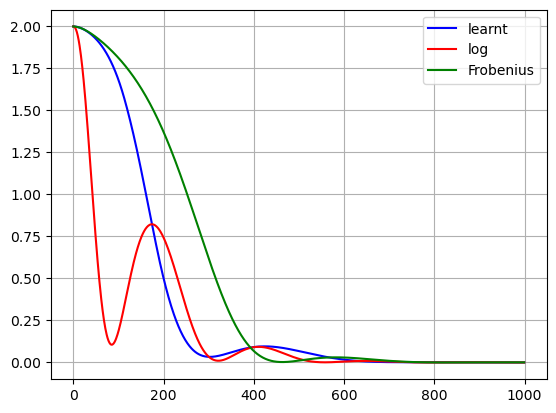

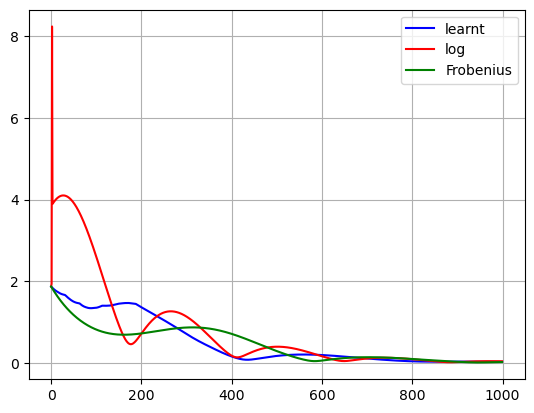

In [70]:
# Test with large initial errors
Rpioff = so3_exp_map(torch.pi*torch.tensor([[1.0, 0.0, 0.0]], dtype = torch.float32, requires_grad = False))[0]
R0_test = so3_exp_map(0.001*torch.randn(1,3, dtype = torch.float32, requires_grad = True))[0]@Rpioff
omega0_test = torch.randn(3,1, dtype = torch.float32, requires_grad = True)

R_NN, omega_NN = model_NN(R0_test, omega0_test)
R_benchmark_log, omega_benchmark_log = model_log(R0_test, omega0_test)
R_benchmark_F, omega_benchmark_F = model_F(R0_test, omega0_test)

Psi_NN = torch.zeros(nSim, dtype = torch.float32)
Psi_benchmark_log = torch.zeros(nSim, dtype = torch.float32)
Psi_benchmark_F = torch.zeros(nSim, dtype = torch.float32)

errorKE_NN = torch.zeros(nSim, dtype = torch.float32)
errorKE_benchmark_log = torch.zeros(nSim, dtype = torch.float32)
errorKE_benchmark_F = torch.zeros(nSim, dtype = torch.float32)

for i in range(len(R_NN)):
    Psi_NN[i] = potentialFunction2(0.5*(RDes.permute(1,0)@R_NN['e'+str(i)]+R_NN['e'+str(i)].permute(1,0)))

    Psi_benchmark_log[i] = potentialFunction2(0.5*(RDes.permute(1,0)@R_benchmark_log['e'+str(i)]+R_benchmark_log['e'+str(i)].permute(1,0)))
    Psi_benchmark_F[i] = potentialFunction2(0.5*(RDes.permute(1,0)@R_benchmark_F['e'+str(i)]+R_benchmark_F['e'+str(i)].permute(1,0)))
    errorKE_NN[i] = torch.norm(omega_NN['e'+str(i)])
    errorKE_benchmark_log[i] = torch.norm(omega_benchmark_log['e'+str(i)])
    errorKE_benchmark_F[i] = torch.norm(omega_benchmark_F['e'+str(i)])
    
plt.plot(Psi_NN.detach().numpy(), 'b-', label='learnt')
plt.plot(Psi_benchmark_log.detach().numpy(), 'r-', label='log')
plt.plot(Psi_benchmark_F.detach().numpy(), 'g-', label='Frobenius')

plt.grid()
plt.legend()
plt.show()

plt.plot(errorKE_NN.detach().numpy(), 'b-', label='learnt')
plt.plot(errorKE_benchmark_log.detach().numpy(), 'r-', label='log')
plt.plot(errorKE_benchmark_F.detach().numpy(), 'g-', label='Frobenius')
plt.grid()
plt.legend()
plt.show()
    
    
    
    
